# driver_monolithic_NMROM
Driver to implement and test NM ROM on the 2D Burgers Equation.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import cm
import matplotlib.colors as colors
import scipy.sparse as sp
import scipy.linalg as la
from time import time
import dill as pickle
import os
from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model
from utils.monolithic_LSROM import compute_basis_from_svd #, select_sample_nodes
# from utils.NM_ROM import DD_NM_ROM, separate_snapshots, compute_residual_bases, RBFmdl, get_net_np_params, sp_diag
from utils.monolithic_NMROM import monolithic_NMROM, monolithic_NMROM_HR
from utils.newton_solve import gauss_newton
from scipy.interpolate import RBFInterpolator

/usr/workspace/diaz64/anaconda/envs/opence-1.7.2-cuda-11.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

## Set model parameters

In [3]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]

a1, lam = 7692.5384, 21.9230
viscosity = 1e-1

print(f'a1, lam = {a1, lam}')

# number of subdomains in x and y directions for DD model
n_sub_x = 1
n_sub_y = 1

n_sub   = n_sub_x*n_sub_y
fig_dir1 = fig_dir0 + f'nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
fig_dir  = fig_dir1 + f'a1_{a1}_lam_{lam}/'
svd_dir  = data_dir + f'nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
nm_figs  = fig_dir + 'nmrom/'
for d in [fig_dir1, fig_dir, nm_figs]:
    if not os.path.exists(d):
        os.mkdir(d)
if not os.path.exists(svd_dir): print('Error: Must run LS-ROM notebook before proceeding.')

a1, lam = (7692.5384, 21.923)


In [4]:
# load snapshot and residual data
file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_{400}.p'
data = pickle.load(open(file, 'rb'))
Mu = data['parameters']
snapshots = data['snapshots']
residuals = data['residuals']

## Solve monolithic FOM

In [5]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving monolithic FOM:')
start = time()
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=True)
fom_time = time()-start
sol_fd = np.concatenate([u_fom, v_fom])

Solving monolithic FOM:
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      5.007e+06
   1       1.000e+00      1.764e+05
   2       1.000e+00      2.570e+04
   3       1.000e+00      2.397e+03
   4       1.000e+00      2.035e+02
   5       1.000e+00      1.730e+01
   6       1.000e+00      1.478e+00
   7       1.000e+00      1.268e-01
   8       1.000e+00      1.095e-02
   9       1.000e+00      9.516e-04
  10       1.000e+00      8.342e-05
  11       1.000e+00      7.379e-06
  12       1.000e+00      6.594e-07
  13       1.000e+00      5.962e-08
  14       1.000e+00      5.913e-09
Newton solver terminated after 14 iterations with residual 5.9127e-09.


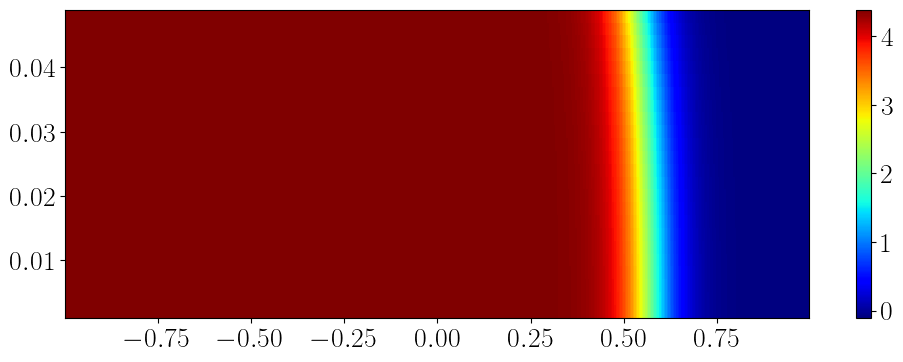

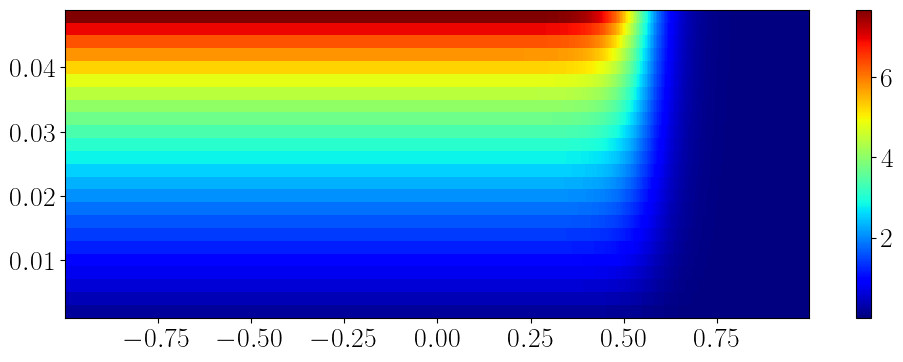

In [6]:
# plot DD FOM u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_fom = u_fom.reshape(ny, nx)
V_fom = v_fom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_fom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = fig_dir+'u_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_fom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
# plt.xlabel('$x$')
# plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = fig_dir+'v_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Generate NM-ROM class

In [7]:
ec     = 1e-10          # energy criteria for number of interior and interface basis vectors
nbasis = -1             # number of residual basis vectors. set to -1 to use energy criteria

# load SVD data
print('Loading residual SVD data...')
res_dict  = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
print('Data loaded!')

# compute bases
print('Computing residual basis...')
residual_basis = compute_basis_from_svd(res_dict, ec=ec, nbasis=nbasis)
print('Bases computed!')

print(f'residual_basis.shape={residual_basis.shape}')

Loading residual SVD data...
Data loaded!
Computing residual basis...
Bases computed!
residual_basis.shape=(23040, 82)


In [8]:
# autoencoder parameters
latent_dim = 9
row_nnz    = 5
row_shift  = 5
act_type   = 'Swish'

Ntotal = 6400 if nx in [240, 480] else 4200
net_folder0 = f'./trained_nets/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/sub_1of1/'
net_name = net_folder0+\
           f'ld_{latent_dim}_rnnz_{row_nnz}_rshift_{row_shift}_'+\
           f'{act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_dict = torch.load(net_name, map_location=device)

In [9]:
# instatiate NM-ROM
nmrom = monolithic_NMROM(fom, net_dict)

Using device: cuda


In [10]:
# train RBF interpolator for initial iterate
enc_snapshots = np.vstack([nmrom.encoder(s) for s in snapshots])
rbfmdl = RBFInterpolator(Mu, enc_snapshots, neighbors=None, kernel='linear')

In [11]:
# solve nmrom
start = time()
w0 = rbfmdl(np.array([[a1,lam]])).reshape(-1,) # compute initial iterate
w, res_hist, step_hist, iter = nmrom.solve(w0, tol=1e-3, maxit=5, print_hist=True)
rom_time = time()-start
nmrom_rel_err = np.linalg.norm(sol_fd-nmrom.decoder(w)[0])/np.linalg.norm(sol_fd)
print(f'DD-ROM rel. error = {nmrom_rel_err:1.4e}')
print(f'Speedup = {fom_time/rom_time}')

iter       Stepsize       ||RTr||
   0       0.000e+00      7.191e+11
   1       1.000e+00      1.476e+11
   2       1.000e+00      8.238e+09
   3       1.000e+00      3.325e+08
   4       1.000e+00      2.508e+07
   5       1.000e+00      1.915e+06
Newton failed to converge in 5 iterations.
DD-ROM rel. error = 1.0798e-03
Speedup = 12.582389586886158


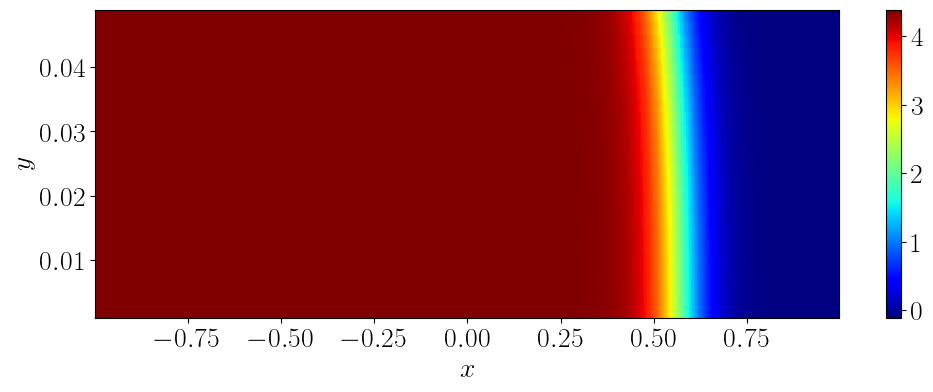

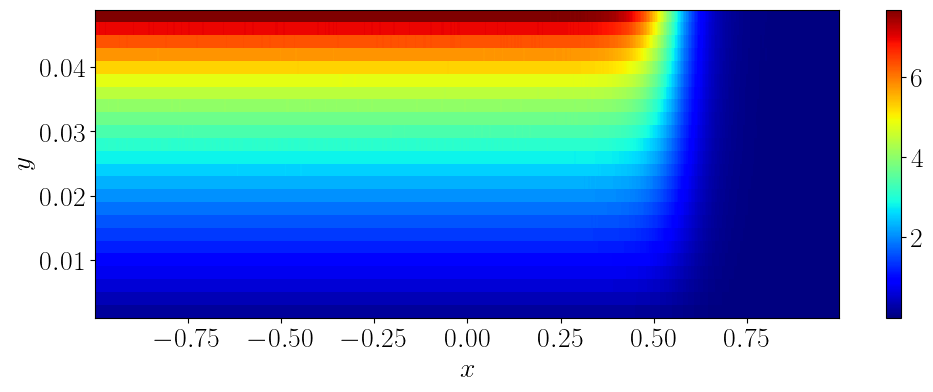

In [12]:
# plot rom solutions
uv_rom = nmrom.decoder(w)[0]
u_rom = uv_rom[:nmrom.nxy]
v_rom = uv_rom[nmrom.nxy:]
U_rom = u_rom.reshape(ny, nx)
V_rom = v_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = nm_figs+'u_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = nm_figs+'v_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

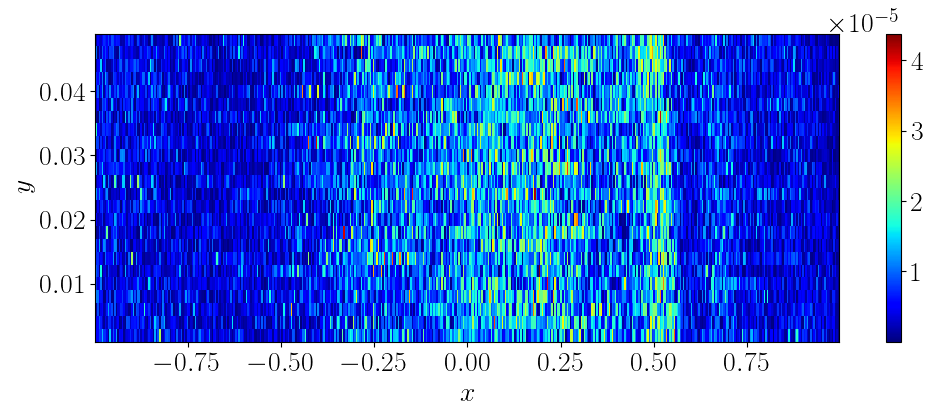

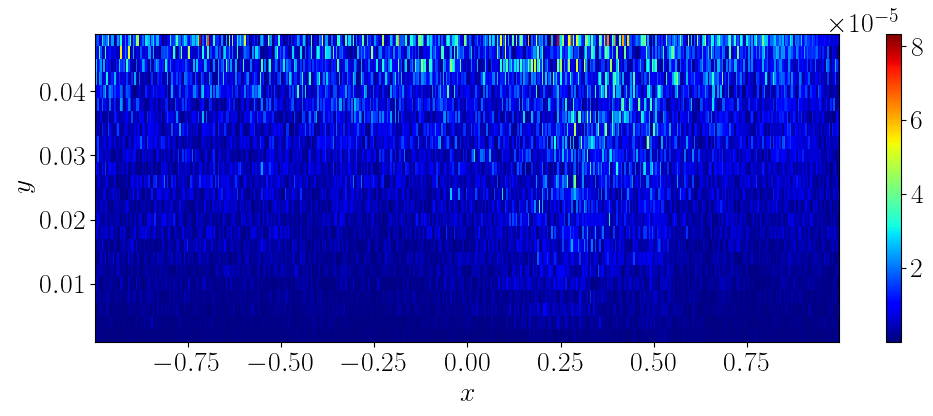

In [13]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = nm_figs+f'u_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = nm_figs+f'v_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## NMROM with HR

In [14]:
# instantiate NMROM with HR
nmromhr = monolithic_NMROM_HR(fom, net_dict, residual_basis, sample_ratio=2, n_samples=-1)

Using device: cuda


In [15]:
# train RBF interpolator for initial iterate
enc_snapshots = np.vstack([nmromhr.encoder(s) for s in snapshots])
rbfmdl = RBFInterpolator(Mu, enc_snapshots, neighbors=None, kernel='linear')

In [16]:
# solve nmrom
start = time()
w0 = rbfmdl(np.array([[a1,lam]])).reshape(-1,) # compute initial iterate
w_hr, res_hist, step_hist, iter = nmromhr.solve(w0, tol=1e-3, maxit=5, print_hist=True)
hr_rom_time = time()-start
nmromhr_rel_err = np.linalg.norm(sol_fd-nmromhr.decoder(w_hr)[0])/np.linalg.norm(sol_fd)
print(f'DD-ROM rel. error = {nmromhr_rel_err:1.4e}')
print(f'Speedup = {fom_time/hr_rom_time}')

iter       Stepsize       ||RTr||
   0       0.000e+00      2.595e+10
   1       1.000e+00      2.786e+09
   2       1.000e+00      1.044e+08
   3       1.000e+00      1.917e+06
   4       1.000e+00      6.201e+04
   5       3.725e-09      6.201e+04
Newton failed to converge in 5 iterations.
DD-ROM rel. error = 1.0011e-03
Speedup = 12.78667214743368


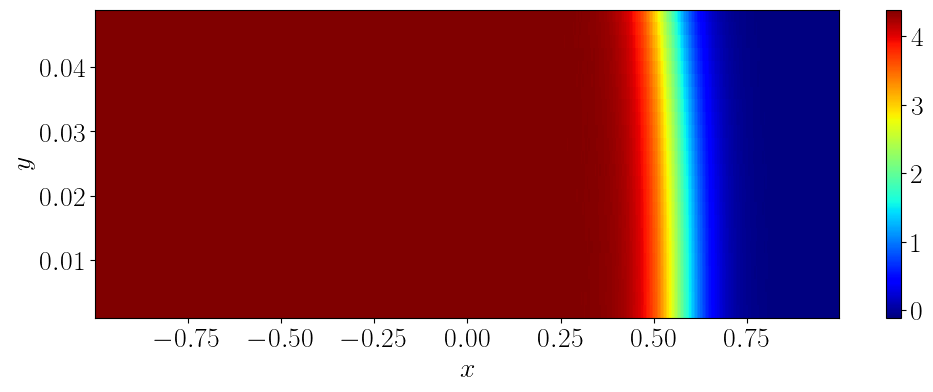

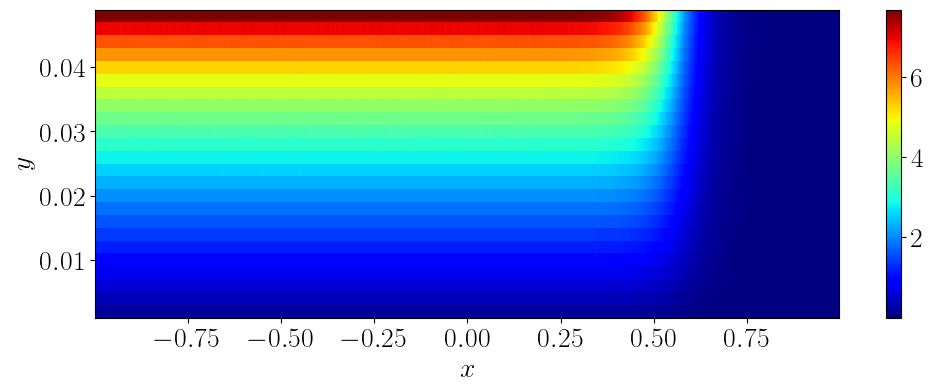

In [17]:
# plot rom solutions
uv_rom = nmromhr.decoder(w_hr)[0]
u_rom = uv_rom[:nmromhr.nxy]
v_rom = uv_rom[nmromhr.nxy:]
U_rom = u_rom.reshape(ny, nx)
V_rom = v_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = nm_figs+'u_col_hr_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = nm_figs+'v_col_hr_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

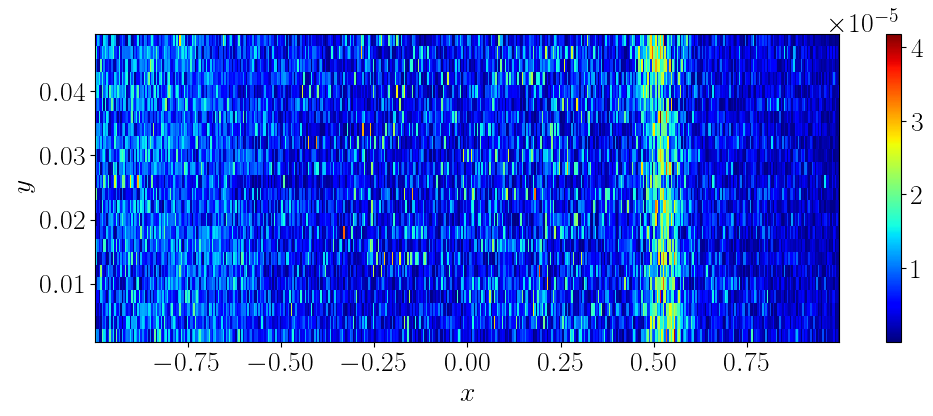

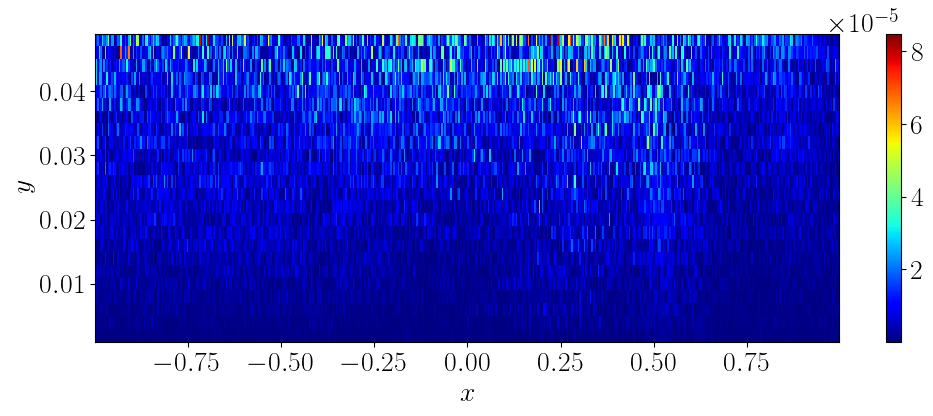

In [18]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = nm_figs+f'u_col_hr_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = nm_figs+f'v_col_hr_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [19]:
n_params = nmrom.en_W1.nnz + nmrom.en_b1.size + np.prod(nmrom.en_W2.shape) \
           + nmrom.de_W2.nnz + nmrom.de_b1.size + np.prod(nmrom.de_W1.shape)

In [20]:
nmromhr.train_time

1970.2460758686066

In [21]:
nmromhr.train_time/1276.4079313278198

1.5435865192556442

In [22]:
n_params

2995100

In [25]:
P = [1.147e6, 5.257e5, 2.617e5, 1.297e5]
red = [(1-p/n_params)*100 for p in P]
red

[61.70411672398251, 82.44799839738239, 91.26239524556776, 95.66959366966044]

In [24]:
[p/3.226e6 for p in P]

[0.3555486670799752,
 0.162957222566646,
 0.08112213267203967,
 0.040204587724736514]